In [14]:
import numpy as np
import readdy
import matplotlib.pyplot as plt
import os
from collections import defaultdict

In [2]:
system = readdy.ReactionDiffusionSystem(box_size=[100, 100, 100])

In [3]:
system.topologies.add_type("Polymer")
system.add_topology_species("Head", .002)
system.add_topology_species("Tail", .002)

In [4]:
system.topologies.configure_harmonic_bond("Head", "Tail", force_constant=50, length=1.)
system.topologies.configure_harmonic_bond("Tail", "Tail", force_constant=50, length=1.)
system.topologies.configure_harmonic_bond("Head", "Head", force_constant=50, length=1.)
system.topologies.configure_harmonic_angle("Head", "Tail", "Tail", force_constant=10, equilibrium_angle=np.pi)
system.topologies.configure_harmonic_angle("Tail", "Tail", "Tail", force_constant=10, equilibrium_angle=np.pi)

In [5]:
# dissociation
def dissociation_rate_function(topology):
    edges = topology.get_graph().get_edges()
    return .000005 * float(len(edges)) if len(edges) > 2 else 0.
def dissociation_reaction_function(topology):
    recipe = readdy.StructuralReactionRecipe(topology)
    edges = topology.get_graph().get_edges()
    vertices = topology.get_graph().get_vertices()
    
    # at least a structure like
    # v1 -- v2 -- v3 -- v4
    if len(edges) > 2:
        # find the end particles
        counts = defaultdict(int)
        for e in edges:
            pix1 = e[0].get().particle_index
            pix2 = e[1].get().particle_index
            counts[pix1] += 1
            counts[pix2] += 1
        
        # the end particles are the ones that have exactly one edge leading from/to them
        endpoints = []
        for pix in counts.keys():
            if counts[pix] == 1:
                endpoints.append(pix)

        assert len(endpoints) == 2, "the number of end points should always be 2 \
                but was {} (counts: {})".format(len(endpoints), counts)

        # draw an edge excluding the edges leading to the both ends
        edge_index = np.random.randint(0, len(edges) - 2)
        removed_edge = None
        # for each edge in the graph
        for e in edges:
            pix1 = e[0].get().particle_index
            pix2 = e[1].get().particle_index
            # check if it belongs to one of the end vertices
            if pix1 not in endpoints and pix2 not in endpoints:
                # if not, reduce edge_index until 0
                if edge_index == 0:
                    # remove this edge
                    recipe.remove_edge(e)
                    removed_edge = e
                    break
                else:
                    edge_index -= 1

        assert removed_edge is not None

        pix1 = removed_edge[0].get().particle_index
        pix2 = removed_edge[1].get().particle_index

        assert pix1 not in endpoints
        assert pix2 not in endpoints

        # since the edge was removed we now have two topologies and need to set the correct particle types
        recipe.change_particle_type([vix for vix, v in enumerate(vertices) if v.particle_index == pix1][0], "Head")
        recipe.change_particle_type([vix for vix, v in enumerate(vertices) if v.particle_index == pix2][0], "Head")
    else:
        print("this should not have happened")
    return recipe
system.topologies.add_structural_reaction("Polymer", dissociation_reaction_function, dissociation_rate_function)

In [6]:
system.topologies.add_spatial_reaction("Association: Polymer(Head) + Polymer(Head) -> Polymer(Tail--Tail)", 
                                       rate=1.0, radius=1.0)

In [7]:
simulation = system.simulation(kernel="CPU")

In [8]:
# randomly place some polymers of length 4
n_polymers = 500
for head in range(n_polymers):
    head_position = 80. * np.random.random((1, 3)) - 40.
    offset1 = 2.*np.random.random((1, 3))-1.
    offset1 /= np.linalg.norm(offset1)
    tail1 = head_position + offset1
    offset2 = 2.*np.random.random((1, 3))-1.
    offset2 /= np.linalg.norm(offset2)
    tail2 = head_position + offset1 + offset2
    offset3 = 2.*np.random.random((1, 3)) - 1.
    offset3 /= np.linalg.norm(offset3)
    head_position2 = head_position + offset1 + offset2 + offset3

    top = simulation.add_topology("Polymer", ["Head", "Tail", "Tail", "Head"],
                                  np.array([head_position, tail1, tail2, head_position2]).squeeze())
    top.get_graph().add_edge(0, 1)
    top.get_graph().add_edge(1, 2)
    top.get_graph().add_edge(2, 3)

In [9]:
simulation.output_file = '/srv/public/clonker/out/living_polymers.h5'
simulation.observe.topologies(300)
simulation.record_trajectory(300)
simulation.progress_output_stride = 10
simulation.show_progress = True

In [10]:
timestep = 1.
if os.path.exists(simulation.output_file):
    os.remove(simulation.output_file)
simulation.run(500000, timestep)

Configured kernel context with:
--------------------------------
 - kBT = 2.43614
 - periodic b.c. = (true, true, true)
 - box size = (100, 100, 100)
 - particle types:
     * Topology particle type "Tail" with D=0.002
     * Topology particle type "Head" with D=0.002
 - topology potential configuration:
     - bonds (3):
         - Bonds for particle types Head and Head:
             * Harmonic bond with force constant 50 and length 1
         - Bonds for particle types Head and Tail:
             * Harmonic bond with force constant 50 and length 1
         - Bonds for particle types Tail and Tail:
             * Harmonic bond with force constant 50 and length 1
     - angles (2):
             * Harmonic angle with force constant 10 and equilibrium angle 3.14159
             * Harmonic angle with force constant 10 and equilibrium angle 3.14159
 - topology types:
     * topology type "Polymer" with 1 structural reactions
 - spatial topology reactions:
     * Topology-topology fusion re

HBox(children=(HBox(children=(Label(value='Simulation progress'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=50000), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

In [11]:
# read back topologies
t = readdy.Trajectory(simulation.output_file)
time, topology_records = t.read_observable_topologies()

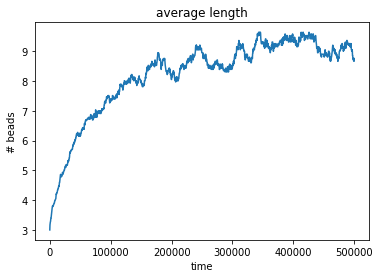

In [12]:
# gather average length of topologies for respective time step
avg_length = []
# for each time step
for topologies in topology_records:
    # gather average polymer length
    avg_length.append(0)
    for top in topologies:
        avg_length[-1] += len(top.edges)
    avg_length[-1] /= len(topologies)
f, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(time, avg_length)
ax.set_title('average length')
ax.set_xlabel('time')
ax.set_ylabel('# beads')
plt.show()

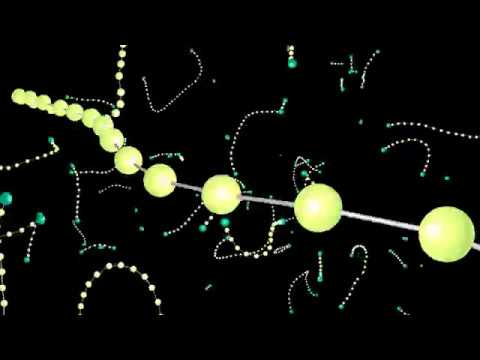

In [13]:
from IPython.display import YouTubeVideo
YouTubeVideo('1fZqbZRQnEQ')